In [1]:
import numpy as np
import pandas

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

import mapalgo as MAP
import viewmap

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import importlib
importlib.reload(MAP)
importlib.reload(viewmap)

<module 'viewmap' from '/Users/dbeach/Desktop/stableyes/src/viewmap.py'>

# Load 1985 Automobiles Data Set

In [5]:
autos = pandas.read_csv("../data/automobiles.csv", na_values="?")
autos[0:10]

symbolizing  normalized_losses         make fuel_type aspiration  \
0            3                NaN  alfa-romero       gas        std   
1            3                NaN  alfa-romero       gas        std   
2            1                NaN  alfa-romero       gas        std   
3            2              164.0         audi       gas        std   
4            2              164.0         audi       gas        std   
5            2                NaN         audi       gas        std   
6            1              158.0         audi       gas        std   
7            1                NaN         audi       gas        std   
8            1              158.0         audi       gas      turbo   
9            0                NaN         audi       gas      turbo   

  num_of_doors   body_style drive_wheels engine_location  wheel_base   ...     \
0          two  convertible          rwd           front        88.6   ...      
1          two  convertible          rwd           front        88.6   ...      
2          two    hatchback          rwd           front        94.5   ...      
3         four        sedan          fwd           front        99.8   ...      
4         four        sedan          4wd           front        99.4   ...      
5          two        sedan          fwd           front        99.8   ...      
6         four        sedan          fwd           front       105.8   ...      
7         four        wagon          fwd           front       105.8   ...      
8         four        sedan          fwd           front       105.8   ...      
9          two    hatchback          4wd           front        99.5   ...      

   engine_size  fuel_system  bore  stroke compression_ratio horsepower  \
0          130         mpfi  3.47    2.68               9.0      111.0   
1          130         mpfi  3.47    2.68               9.0      111.0   
2          152         mpfi  2.68    3.47               9.0      154.0   
3          109         mpfi  3.19    3.40              10.0      102.0   
4          136         mpfi  3.19    3.40               8.0      115.0   
5          136         mpfi  3.19    3.40               8.5      110.0   
6          136         mpfi  3.19    3.40               8.5      110.0   
7          136         mpfi  3.19    3.40               8.5      110.0   
8          131         mpfi  3.13    3.40               8.3      140.0   
9          131         mpfi  3.13    3.40               7.0      160.0   

   peak_rpm city_mpg  highway_mpg    price  
0    5000.0       21           27  13495.0  
1    5000.0       21           27  16500.0  
2    5000.0       19           26  16500.0  
3    5500.0       24           30  13950.0  
4    5500.0       18           22  17450.0  
5    5500.0       19           25  15250.0  
6    5500.0       19           25  17710.0  
7    5500.0       19           25  18920.0  
8    5500.0       17           20  23875.0  
9    5500.0       16           22      NaN  

[10 rows x 26 columns]

# Define Spaces

1. Engine space = attributes describing the car's engine
2. Body space = physical attributes of the car body

For simplicity, we restrict ourselves to continuous valued attributes of the data.

In [6]:
meta_attrs = [
    "make", "fuel_type", "aspiration", "num_of_doors", "body_style",
    "drive_wheels", "engine_location", "num_of_cylinders", "fuel_system"]

engine_attrs = [
    "engine_size", "bore", "stroke",
    "compression_ratio", "horsepower", "peak_rpm"
]

body_attrs = [
    "length", "width", "height",
    "wheel_base", "curb_weight"
]

Let's create dataframes for engine and body space.  For each dataframe, we use z-scoring to normalize the scale of the different attributes.

In [7]:
avail_data = autos[meta_attrs + engine_attrs + body_attrs].dropna()
engine_data = MAP.zscore(avail_data[engine_attrs].as_matrix())
body_data = MAP.zscore(avail_data[body_attrs].as_matrix())

# Create Initial Maps

Here, we create the initial maps for engine space and body space.

In [8]:
engine = MAP.create_map_from_data("Engine", engine_data, perplexity=20.0)
body = MAP.create_map_from_data("Body", body_data, perplexity=20.0)

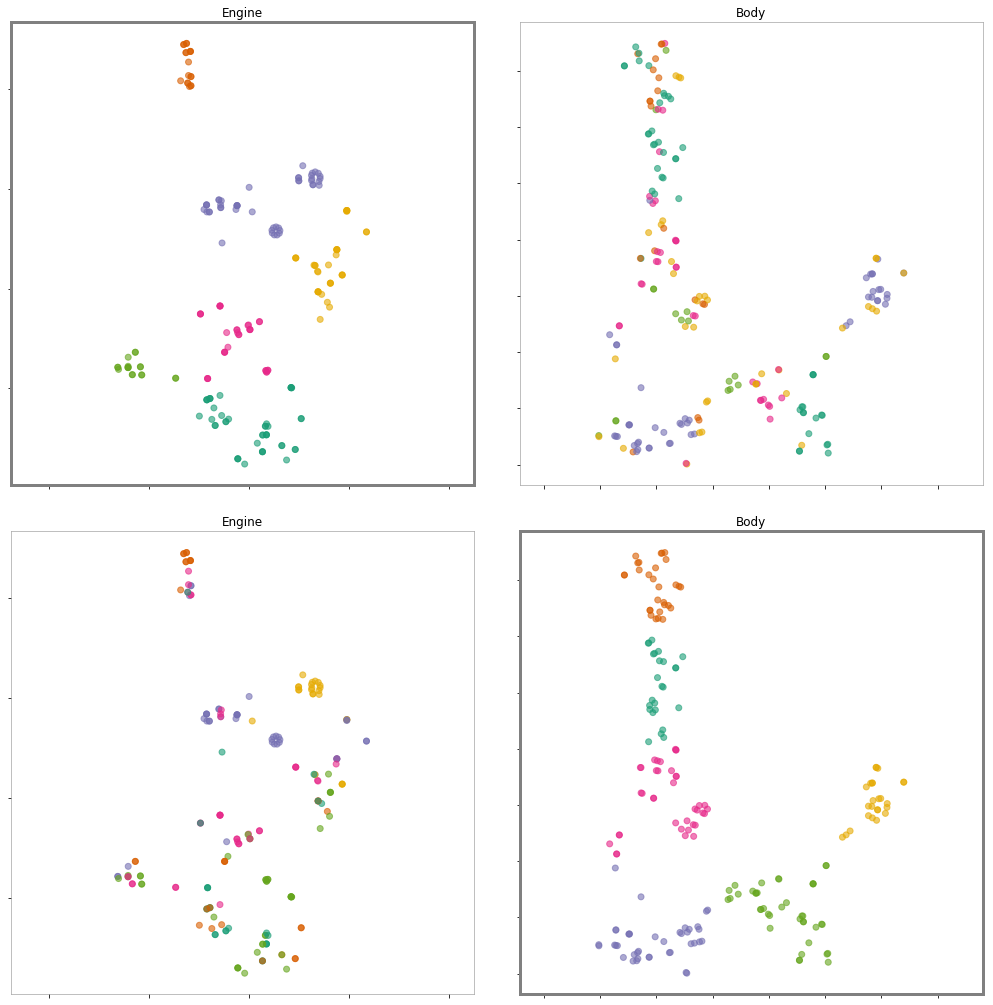

In [10]:
viewmap.show_map_matrix([engine, body], score=False)

# Initial Maps

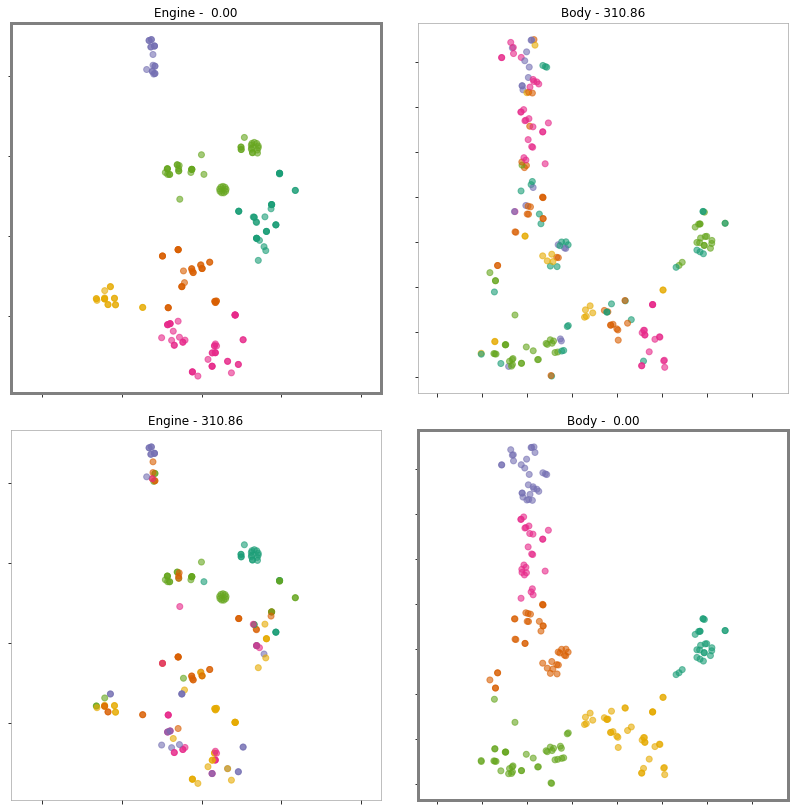

In [12]:
viewmap.show_map_matrix([engine, body], size=12)

# Let the blending begin

## Candidate functions

1. **Data concatenation** &mdash; easy to do,
2. **Weighted mix of probabilities** &mdash; resulting matrix still sums to 1.0, and
3. **Maximum probability** &mdash; try to avoid diluting high-probability relationships; must be renormalized.

# Data Concatenation

In [14]:
concat_data = MAP.zscore(avail_data[engine_attrs + body_attrs].as_matrix())
concat = MAP.create_map_from_data("Concat", concat_data, perplexity=20.0)

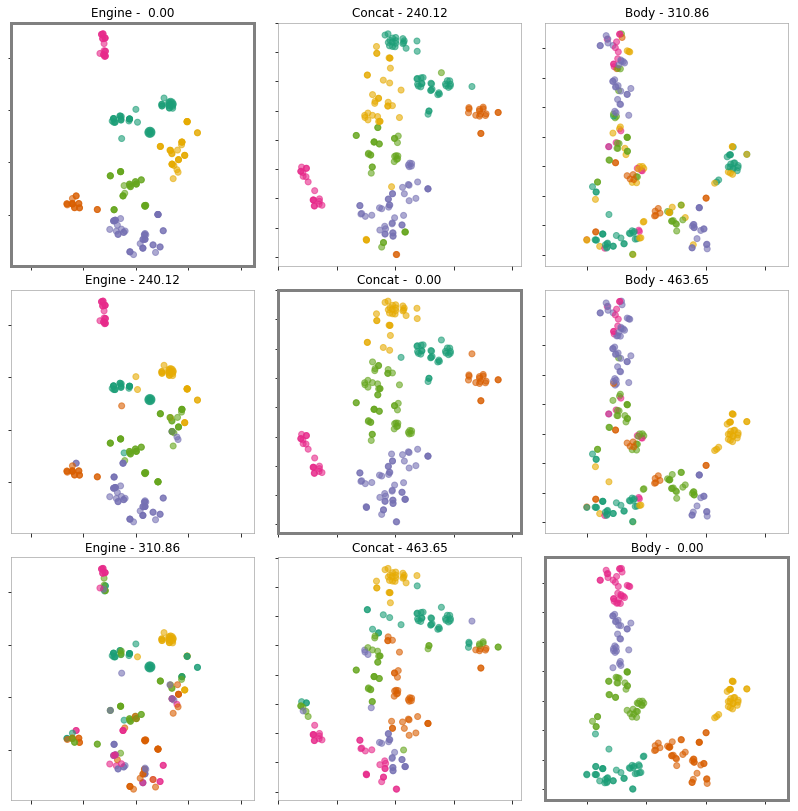

In [16]:
viewmap.show_map_matrix([engine, concat, body], size=12)

# Linear Probability Blending

In [17]:
linear75 = MAP.create_map("Linear 75%", 0.75*engine.prob + 0.25*body.prob)
linear50 = MAP.create_map("Linear 50%", 0.5*engine.prob + 0.5*body.prob)
linear25 = MAP.create_map("Linear 25%", 0.25*engine.prob + 0.75*body.prob)

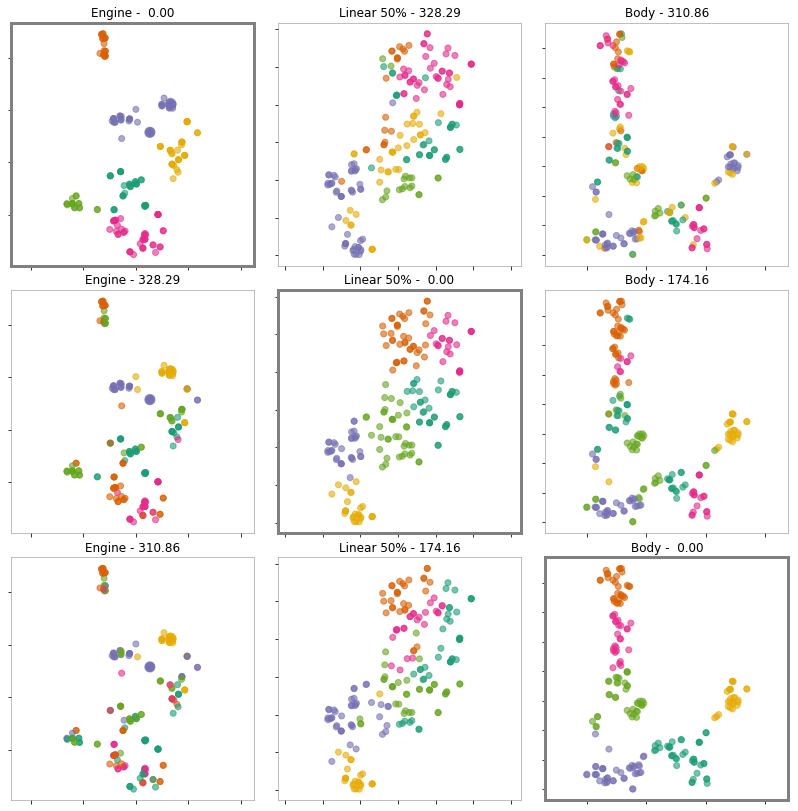

In [18]:
viewmap.show_map_matrix([engine, linear50, body], size=12)

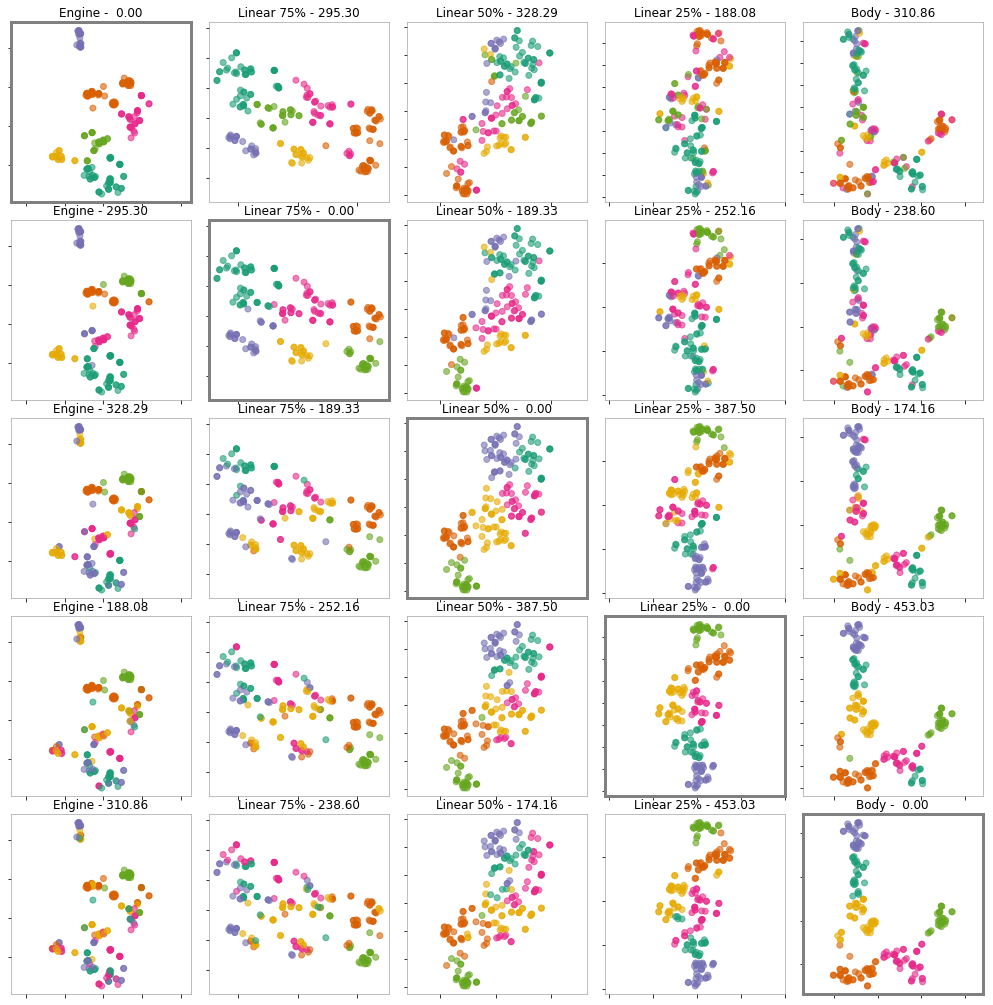

In [19]:
viewmap.show_map_matrix([engine, linear75, linear50, linear25, body])

# Maximum Probability

In [20]:
maximum75 = MAP.create_map("Maximum 75%", np.maximum(0.75*engine.prob, 0.25*body.prob))
maximum50 = MAP.create_map("Maximum 50%", np.maximum(0.50*engine.prob, 0.50*body.prob))
maximum25 = MAP.create_map("Maximum 25%", np.maximum(0.25*engine.prob, 0.75*body.prob))

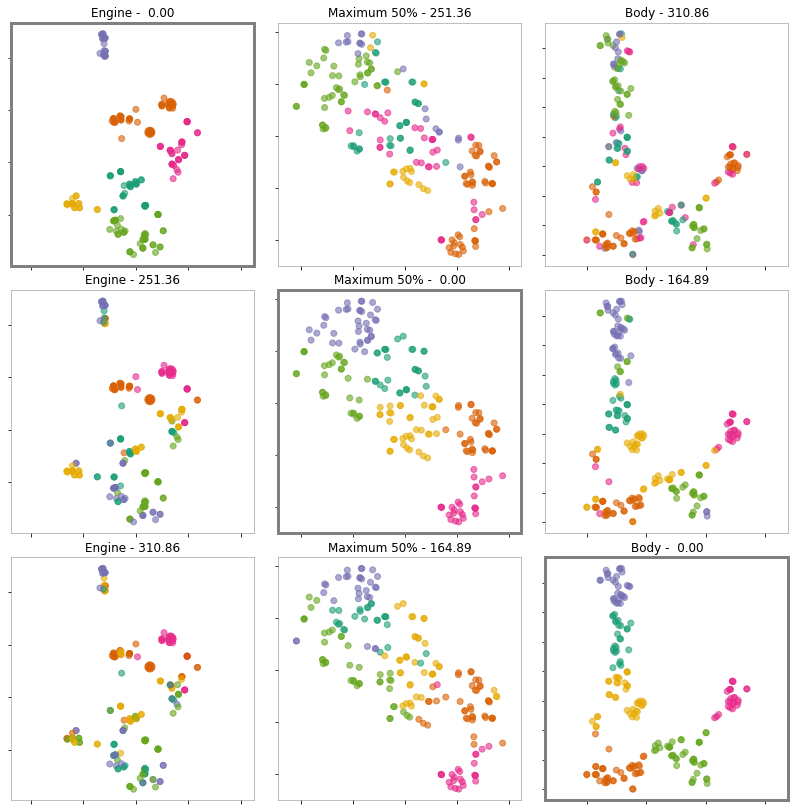

In [21]:
viewmap.show_map_matrix([engine, maximum50, body], size=12)

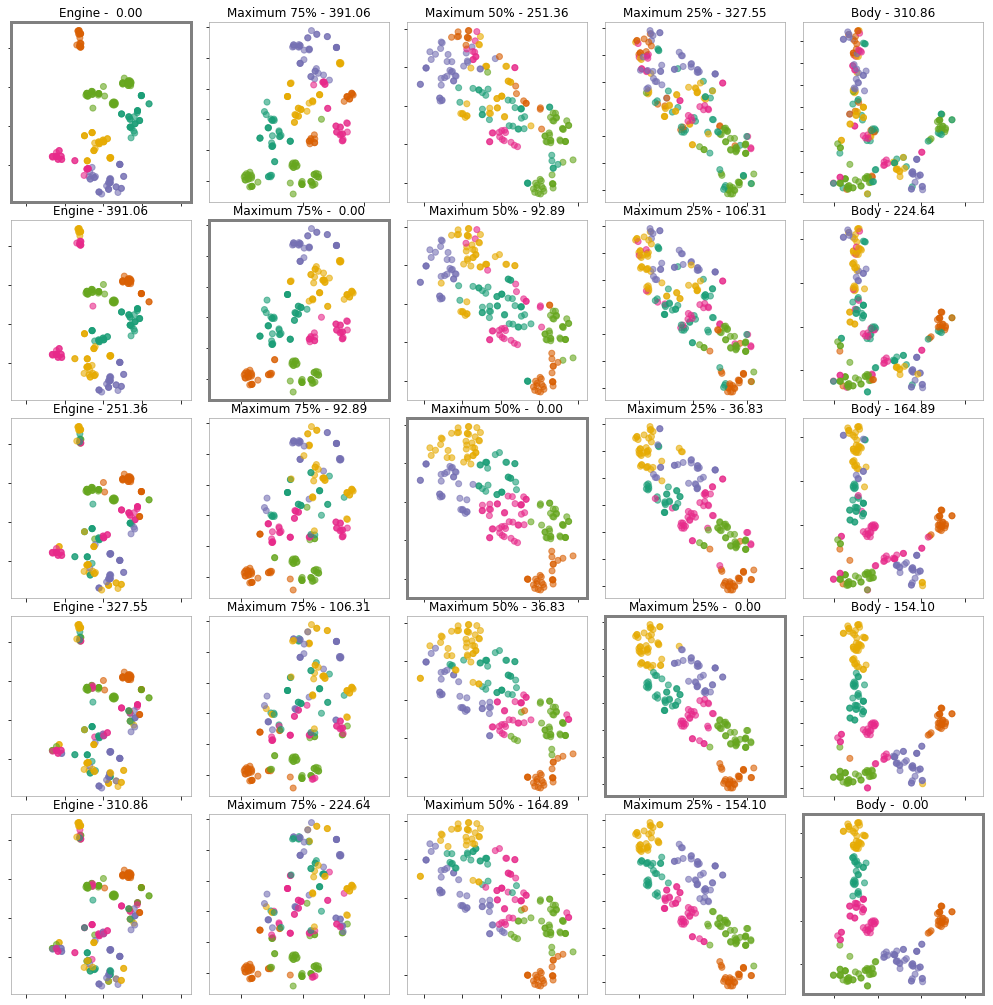

In [22]:
viewmap.show_map_matrix([engine, maximum75, maximum50, maximum25, body])

# Stability

Can we blend probability maps in a way that better preserves the position of clusters?

**Yes we can!**

To do this, we introduce a penalty for moving points too far from their distance in some "anchoring" map.  The penalty is based on the square of the distance, so long-distance moves are highly discouraged.  We will attempt this in gradual steps:

In the following list, each map uses positions which are penalized for being too dis-similar to those in the previous map:

* `Engine` &mdash; starting point
* `Linear A` &mdash; 75% Engine, 25% Body
* `Linear B` &mdash; 50% Engine, 50% Body
* `Linear C` &mdash; 25% Engine, 75% Body
* `Linear D` &mdash; 100% Body

In [23]:
linear_a = MAP.create_map("Linear A", linear75.prob, prior=engine)
linear_b = MAP.create_map("Linear B", linear50.prob, prior=linear_a)
linear_c = MAP.create_map("Linear C", linear25.prob, prior=linear_b)
linear_d = MAP.create_map("Linear D", body.prob, prior=linear_c)

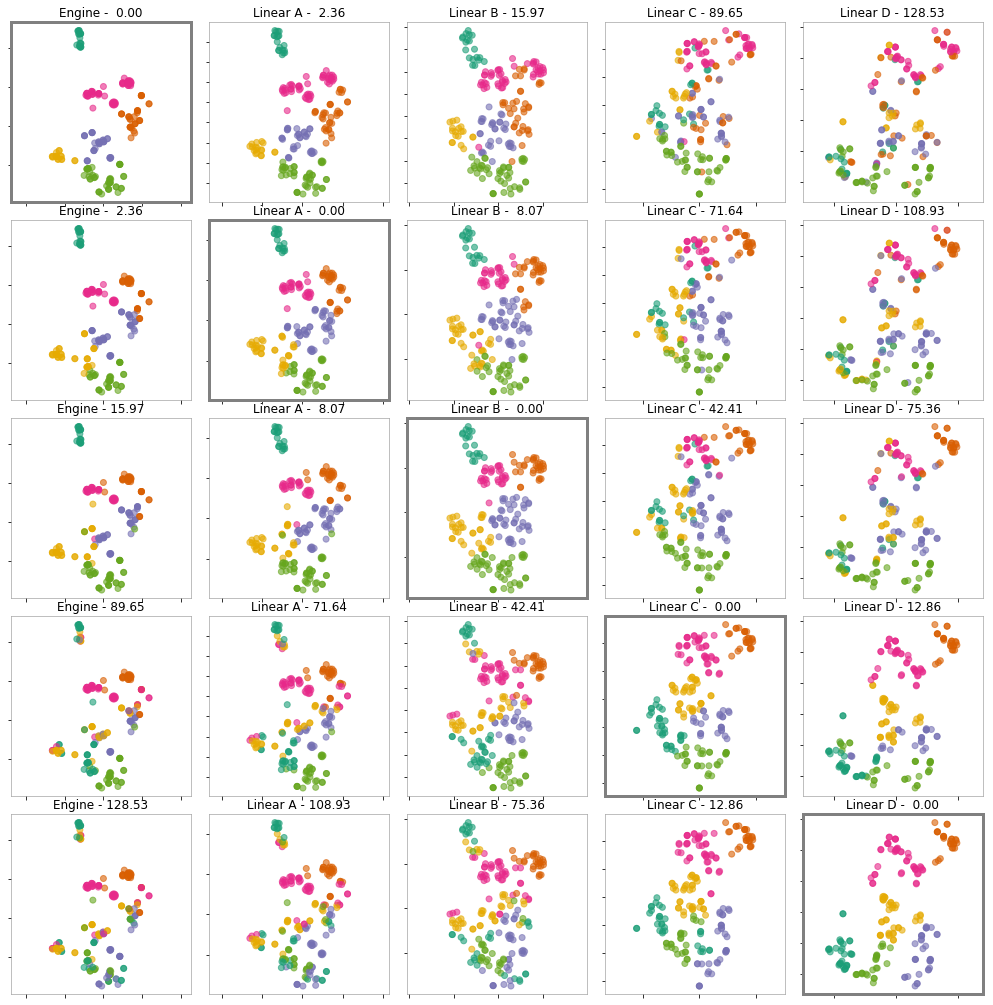

In [24]:
viewmap.show_map_matrix([engine, linear_a, linear_b, linear_c, linear_d])

# Did we arrive at the right place?

**Claim: `Linear D` and `Body` are semantically equal maps.**

* Look at their similarity scores and the visual correspondence of clusters.
* Scores of 1.3 or less are common for maps created from the same probability matrix,
  but using different random initializations.


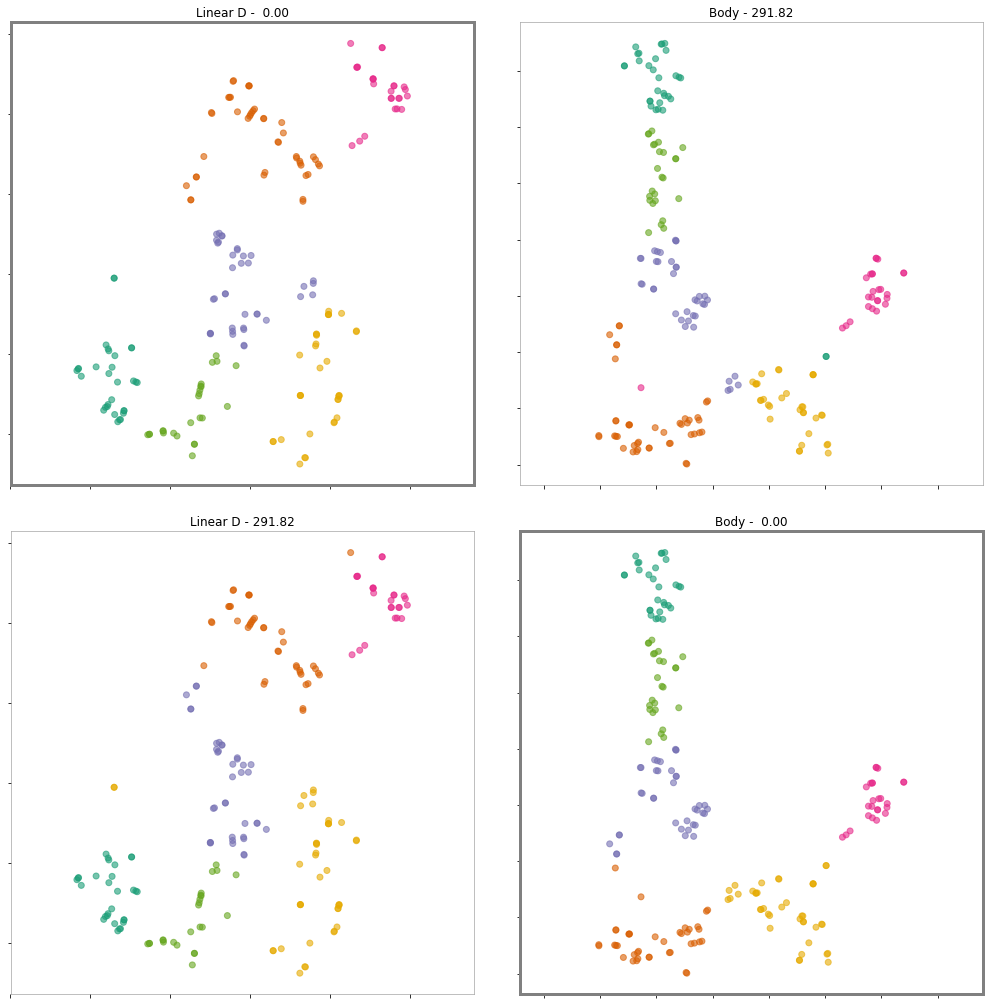

In [25]:
viewmap.show_map_matrix([linear_d, body])

# How many steps are necessary to achieve stability?

* In the previous example, we went through three intermediate steps between Engine space and Body space.
* How many steps are necessary to preserve stability?

**Claim: A single step is sufficient.**

In the code below, we create a new map, `Body 2`, where we try to preserve stability with points in the `Engine` map.

In [26]:
body2 = MAP.create_map("Body 2", body.prob, prior=engine)

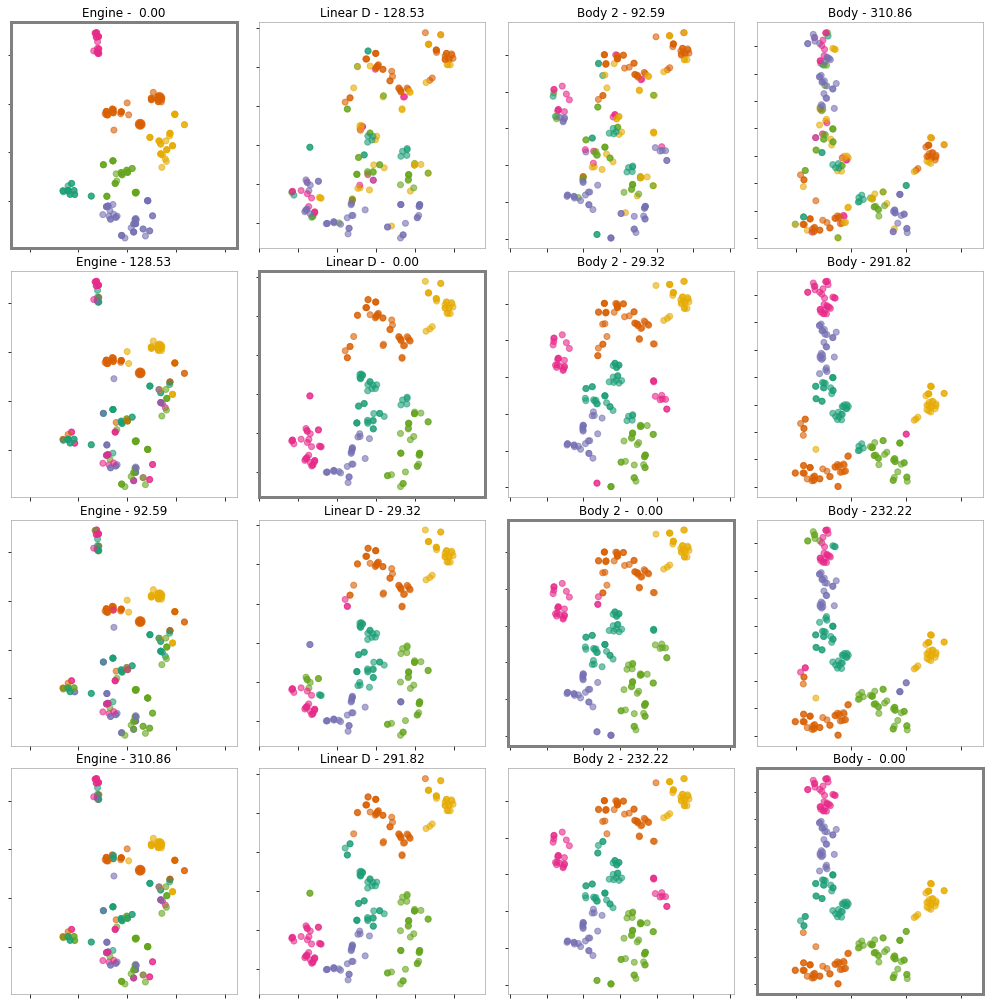

In [27]:
viewmap.show_map_matrix([engine, linear_d, body2, body])

# Conclusion

`Linear D` and `Body 2` are fairly similar maps both semantically and in the spatial orientation of clusters.

Some adjustment of the penalty coefficient may be necessary to avoid distortions.

# Experiments with Varying Perplexity

## Engine Space

In [28]:
engine_p80 = MAP.create_map_from_data("Engine p=80", engine_data, perplexity=80.0, prior=engine)
engine_p40 = MAP.create_map_from_data("Engine p=40", engine_data, perplexity=40.0, prior=engine)
engine_p20 = MAP.create_map_from_data("Engine p=20", engine_data, perplexity=20.0, prior=engine)
engine_p10 = MAP.create_map_from_data("Engine p=10", engine_data, perplexity=10.0, prior=engine)
engine_p5 = MAP.create_map_from_data("Engine p=5", engine_data, perplexity=5.0, prior=engine)

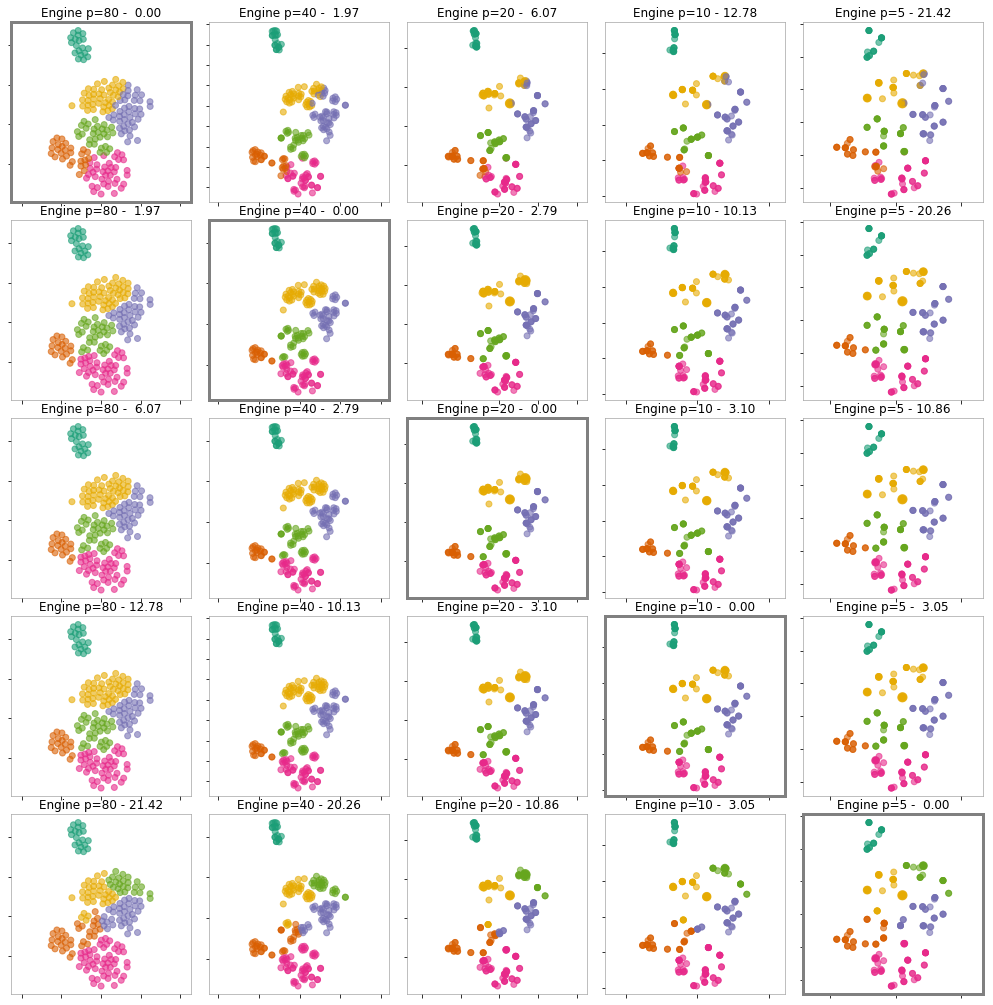

In [29]:
viewmap.show_map_matrix([engine_p80, engine_p40, engine_p20, engine_p10, engine_p5])

## Body Space

In [30]:
body_p80 = MAP.create_map_from_data("Body p=80", body_data, perplexity=80.0, prior=linear_d)
body_p40 = MAP.create_map_from_data("Body p=40", body_data, perplexity=40.0, prior=linear_d)
body_p20 = MAP.create_map_from_data("Body p=20", body_data, perplexity=20.0, prior=linear_d)
body_p10 = MAP.create_map_from_data("Body p=10", body_data, perplexity=10.0, prior=linear_d)
body_p5 = MAP.create_map_from_data("Body p=5", body_data, perplexity=5.0, prior=linear_d)

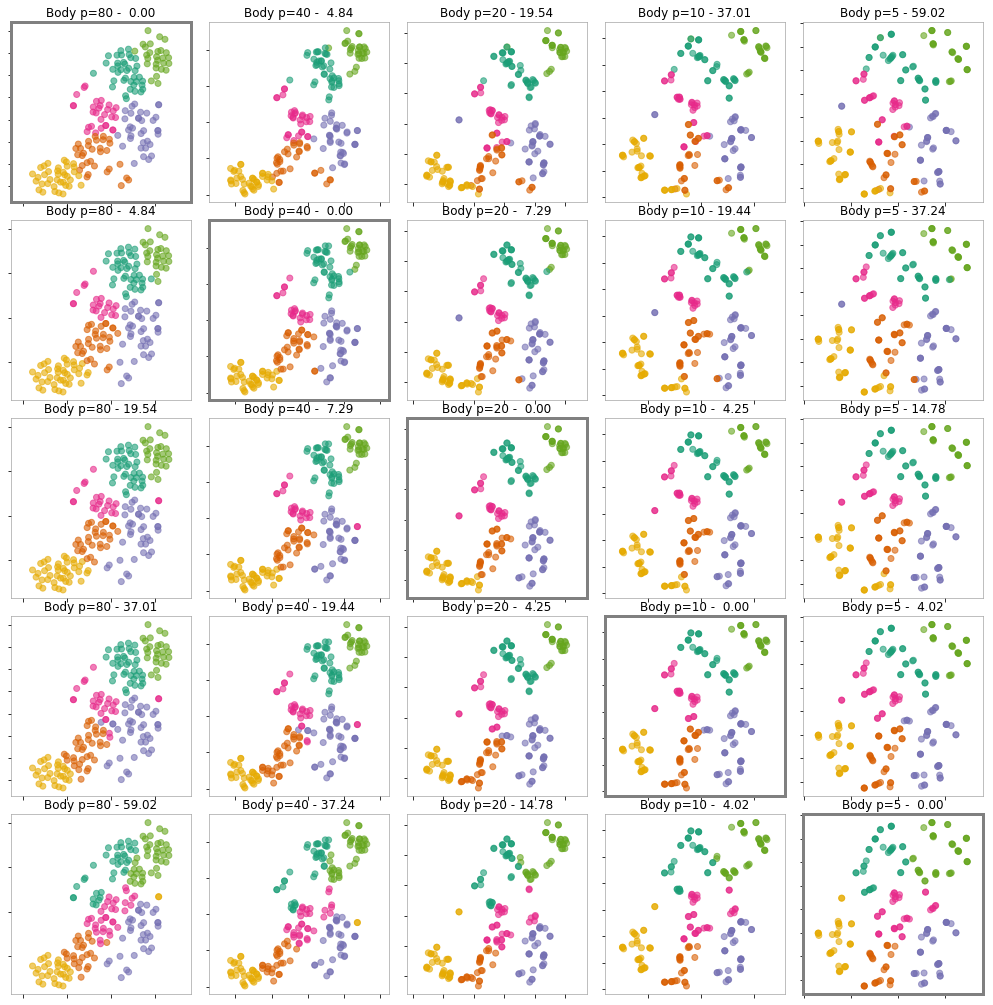

In [31]:
viewmap.show_map_matrix([body_p80, body_p40, body_p20, body_p10, body_p5])

# Ground Truth

* A meager attempt to show relationships between the categorical attributes and the t-SNE mappings.

* Some realtionships are fairly weak,
  but there are some things that pop out.


In [34]:
COLORS = [
    "#1b9e77",
    "#d95f02",
    "#7570b3",
    "#e7298a",
    "#66a61e",
    "#e6ab02",
]

def color_by(ax, map, meta_attr, legend=True):
    vals = avail_data[meta_attr].unique()
    mapping = dict(zip(vals, range(len(vals))))
    colors = [COLORS[mapping[s] % len(COLORS)] for s in avail_data[meta_attr]]
    ax.scatter(map.y[:,0], map.y[:,1], color=colors, s=60)
    if legend:
        for style, idx in mapping.items():
            ax.scatter([], [], color=COLORS[idx], label=style)
        ax.legend()
    ax.axis('equal')
    ax.set_title(f"{map.name} - {meta_attr}")

## Engine Attributes

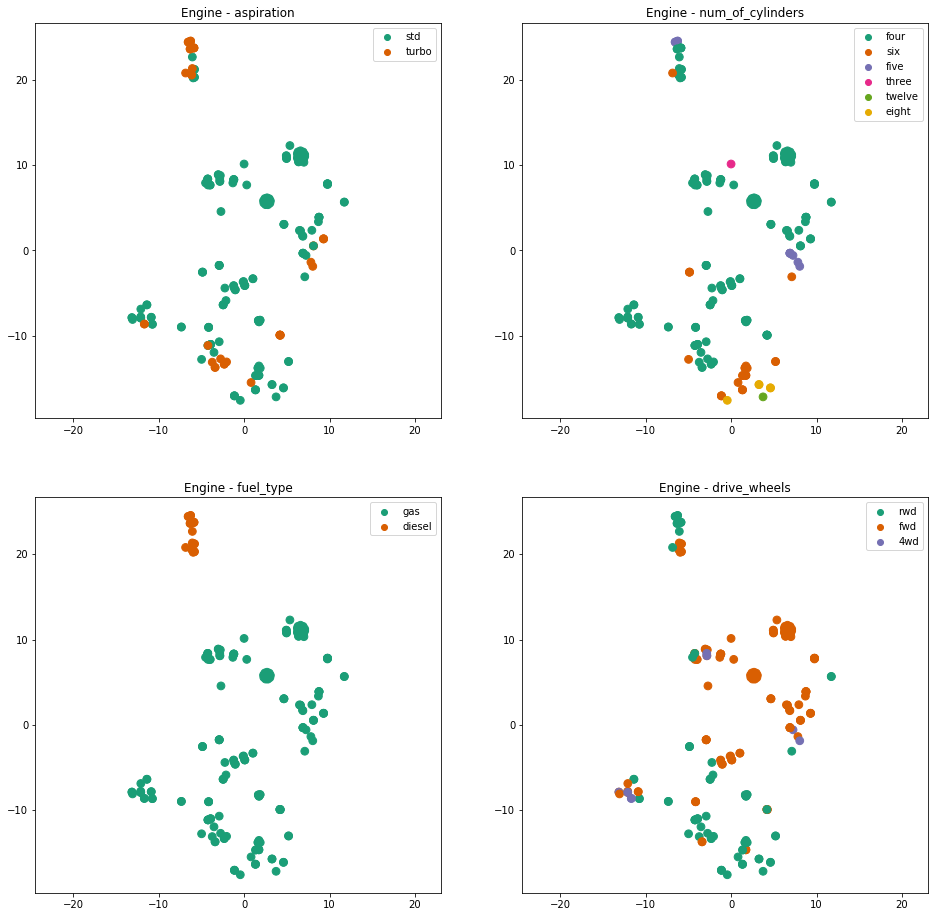

In [35]:
fig, ax = plt.subplots(2, 2, figsize=(16,16))
color_by(ax[0,0], engine, "aspiration")
color_by(ax[0,1], engine, "num_of_cylinders")
color_by(ax[1,0], engine, "fuel_type")
color_by(ax[1,1], engine, "drive_wheels")

## Body Attributes

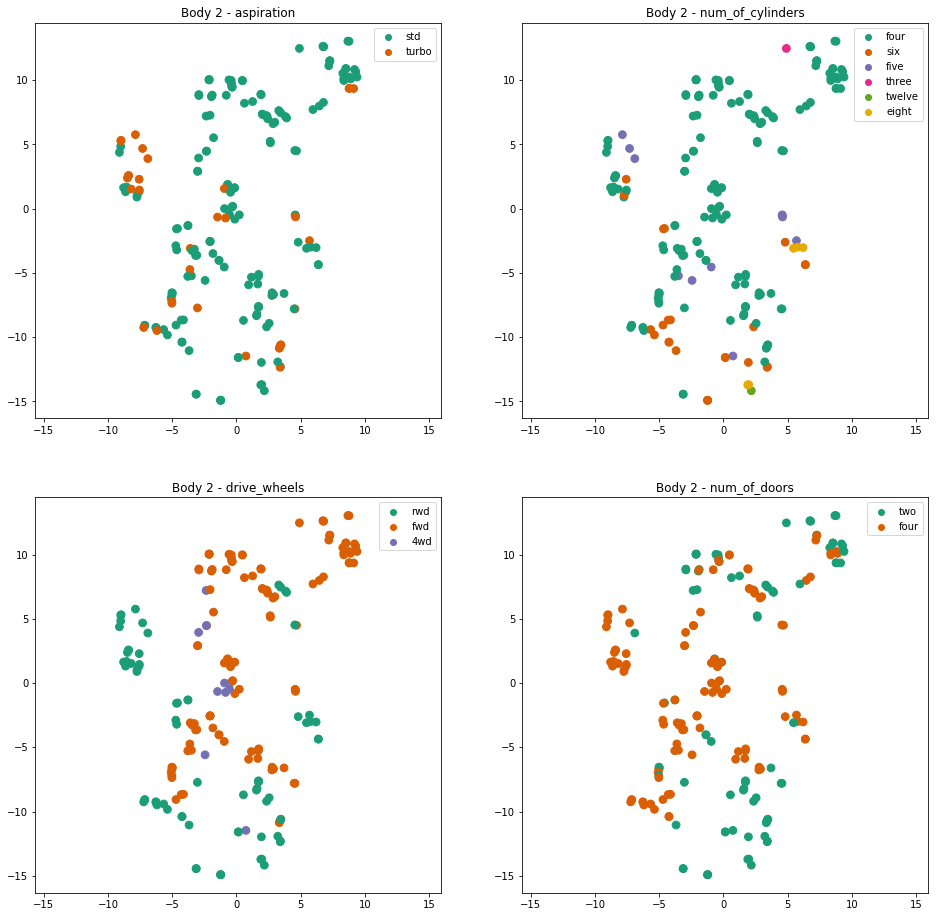

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(16,16))
color_by(ax[0,0], body2, "aspiration")
color_by(ax[0,1], body2, "num_of_cylinders")
color_by(ax[1,0], body2, "drive_wheels")
color_by(ax[1,1], body2, "num_of_doors")

## Blended Maps

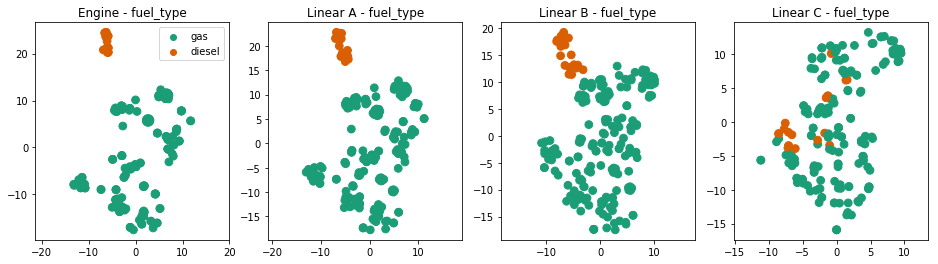

In [37]:
fig, ax = plt.subplots(1, 4, figsize=(16,4))
color_by(ax[0], engine, "fuel_type")
color_by(ax[1], linear_a, "fuel_type", legend=False)
color_by(ax[2], linear_b, "fuel_type", legend=False)
color_by(ax[3], linear_c, "fuel_type", legend=False)

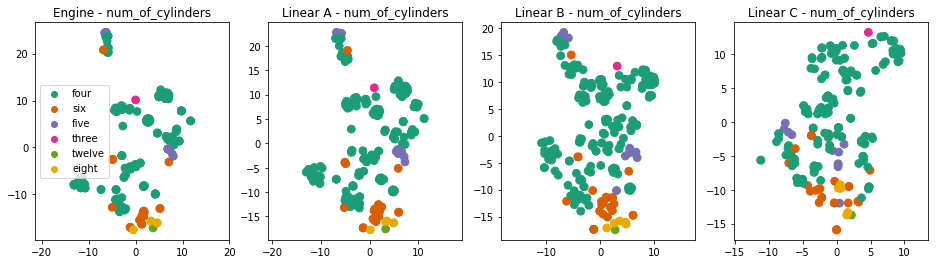

In [38]:
fig, ax = plt.subplots(1, 4, figsize=(16,4))
color_by(ax[0], engine, "num_of_cylinders")
color_by(ax[1], linear_a, "num_of_cylinders", legend=False)
color_by(ax[2], linear_b, "num_of_cylinders", legend=False)
color_by(ax[3], linear_c, "num_of_cylinders", legend=False)

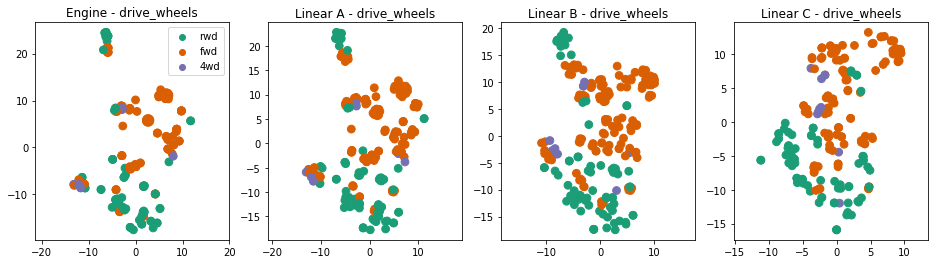

In [39]:
fig, ax = plt.subplots(1, 4, figsize=(16,4))
color_by(ax[0], engine, "drive_wheels")
color_by(ax[1], linear_a, "drive_wheels", legend=False)
color_by(ax[2], linear_b, "drive_wheels", legend=False)
color_by(ax[3], linear_c, "drive_wheels", legend=False)

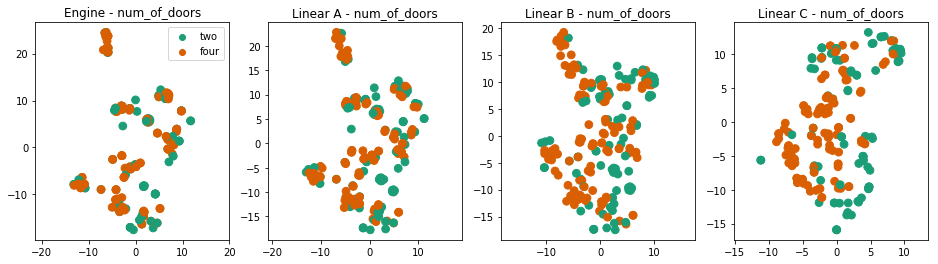

In [40]:
fig, ax = plt.subplots(1, 4, figsize=(16,4))
color_by(ax[0], engine, "num_of_doors")
color_by(ax[1], linear_a, "num_of_doors", legend=False)
color_by(ax[2], linear_b, "num_of_doors", legend=False)
color_by(ax[3], linear_c, "num_of_doors", legend=False)

# User Tasks

1. Uncover relationships across multi-attiribute "maps" via linked highlighting of
  - categorical labels,
  - proximal clusters, and/or
  - linked brushing.

2. For the data cartographer, provide a means of blending existing multi-attribute maps in a way which compromises between the organization these maps.
